# **Pump it Up: Data Mining the Water Table**




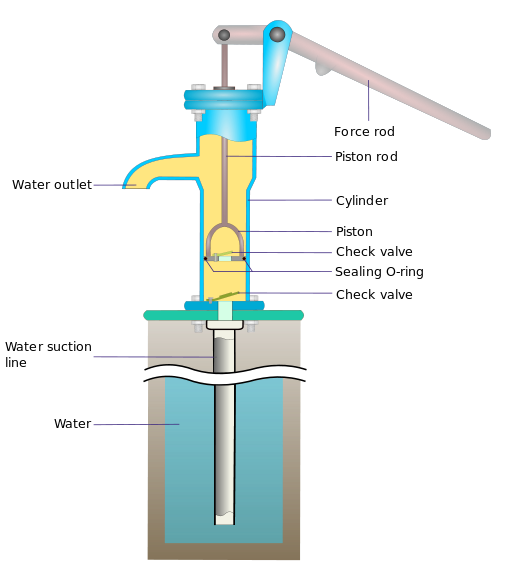

## **Introducción**
Este reto forma parte de [Driven Data Competition Pump it Up: Data Mining the Water Table](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/), que utiliza datos de Taarifa y el Ministerio del Agua de Tanzania. La tarea consiste en buscar soluciones basadas en datos para predecir qué puntos de agua fallarán con el fin de mejorar las operaciones de mantenimiento y garantizar la disponibilidad de agua potable limpia para las comunidades de toda Tanzania.

La tarea es un problema de clasificación multiclase para predecir el estado de las bombas de agua en Tanzania en tres categorías: `funcionando`, `necesita reparación` y `falla`.

www.drivendata.org

Objetivo
Haciendo uso de los datos cargados en la web de Taarifa y el Ministerio de Tanzania del Agua, nuestro objetivo es predecir qué bombas funcionan, cuáles no y cuáles necesitan una reparación. Entender cuáles fallarán es importante por los siguientes motivos:

Predecir la funcionalidad de todas las bombas de agua subterránea que se encuentran en el territorio con modelos precisos, podría ayudar a ahorrarle al gobierno de Tanzania mucho tiempo y dinero.
Estos modelos pueden ayudar a reducir el costo de inspección de cada bomba de agua.
El gobierno puede usar este estudio para saber exactamente cuál es la situación del bombeo de su agua.
El presente trabajo va a estar dividido en tres partes: siendo la primera el Análisis Exploratorio de los Datos, la segunda el Preprocesado de los mismos y la tercera la Selección del Modelo y Entrega.

## **Importamos la librerías necesarias**

In [1]:
!pip install lazypredict

In [2]:
from google.colab import files

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

from scipy.stats.mstats import winsorize
from matplotlib.colors import ListedColormap
import sklearn.neighbors
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split,KFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.svm import SVC # Support Vector Classifier
from sklearn.utils.multiclass import unique_labels

import lazypredict
from lazypredict.Supervised import LazyClassifier
import lightgbm as lgb
import sklearn.externals
import joblib
from sklearn.metrics import accuracy_score

## **Importamos los datos**

In [3]:
train_labels = pd.read_csv("https://raw.githubusercontent.com/carolProg/PROYECTO/main/training_set_labels.csv")
train_values = pd.read_csv("https://raw.githubusercontent.com/carolProg/PROYECTO/main/training_set_values.csv")
test_values = pd.read_csv("https://raw.githubusercontent.com/carolProg/PROYECTO/main/test_set_values.csv")

# **I. Análisis Exploratorio de los Datos**

##  Descripción de los datos
Comenzamos con una pequeña descripción de los datos con los que vamos a trabajar:

###  Características

* **amount_tsh** - Cantidad de agua para bombear
* **date_recorded** - Fecha de inserción de datos
* **funder** - Quién fundó el pozo
* **gps_height** - Altitud del pozo
* **installer** - Organización que lo instaló
* **longitude** - Coordenadas GPS
* **latitude** - Coordenadas GPS
* **wpt_name** - Nombre de la bomba (si es que lo tiene)
* **num_private** - Número
* **basin** - Cuenca geográfica
* **subvillage** - Localización geográfica
* **region** - Localización geográfica
* **region_code** - Localización geográfica (en código)
* **district_code** - Localización geográfica (en código)
* **lga** - Localización geográfica
* **ward** - Localización geográfica
* **population** - Población junto al pozo
* **public_meeting** - Verdadero/Falso
* **recorded_by** - Grupo que introduce estos datos
* **scheme_management** - Quién gestiona la bomba
* **scheme_name** - Quién maneja la bomba
* **permit** - Si la bomba está permitida o no
* **construction_year** - Año de construcción de la bomba
* **extraction_type** - Tipo de extracción de la bomba
* **extraction_type_group** - Tipo de extracción de la bomba
* **extraction_type_class** - Tipo de extracción de la bomba
* **management** - Cómo se gestiona la bomba
* **management_group** - Cómo se gestiona la bomba
* **payment** - Coste del agua
* **payment_type** - Coste del agua
* **water_quality** - Calidad del agua
* **quality_group** - Calidad del agua
* **quantity** - Cantidad de agua
* **quantity_group** - Cantidad de agua
* **source** - Fuente del agua
* **source_type** - Fuente del agua
* **source_class** - Fuente del agua
* **waterpoint_type** - Tipo de bomba
* **waterpoint_type_group** - Tipo de bomba



### **Etiquetas**
Las etiquetas en este dataset son simples. Hay tres valores posibles:

* **functional** - *La bomba funciona y no es necesario repararla*
* **functional needs repair** - *Funciona, pero necesita reparación*
* **non functional** - *La bomba de agua no funciona*

In [4]:
print("# Train Values: {}".format(train_values.shape))
print("# Train Labels: {}".format(train_labels.shape))
print("# Test Values: {}".format(test_values.shape))

# Train Values: (59400, 40)
# Train Labels: (59400, 2)
# Test Values: (14850, 40)


In [5]:
train_labels.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


La variable objetivo es 'status_group' con tres valores posibles:

* 0  functional - La bomba funciona y no es necesario repararla
* 1  functional needs repair - Funciona, pero necesita reparación
* 2  non functional - La bomba de agua no funciona

In [6]:
train_values.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.00,2011-03-14,Roman,1390,Roman,34.94,-9.86,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.00,2013-03-06,Grumeti,1399,GRUMETI,34.70,-2.15,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.00,2013-02-25,Lottery Club,686,World vision,37.46,-3.82,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.00,2013-01-28,Unicef,263,UNICEF,38.49,-11.16,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.00,2011-07-13,Action In A,0,Artisan,31.13,-1.83,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [7]:
test_values.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.00,2013-02-04,Dmdd,1996,DMDD,35.29,-4.06,Dinamu Secondary School,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.00,2013-02-04,Government Of Tanzania,1569,DWE,36.66,-3.31,Kimnyak,0,...,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,0.00,2013-02-01,NaN,1567,NaN,34.77,-5.00,Puma Secondary,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,45559,0.00,2013-01-22,Finn Water,267,FINN WATER,38.06,-9.42,Kwa Mzee Pange,0,...,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
4,49871,500.00,2013-03-27,Bruder,1260,BRUDER,35.01,-10.95,Kwa Mzee Turuka,0,...,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


In [8]:
train_values.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55763 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59398 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [9]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            59400 non-null  int64 
 1   status_group  59400 non-null  object
dtypes: int64(1), object(1)
memory usage: 928.2+ KB


In [10]:
test_values.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14850 entries, 0 to 14849
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     14850 non-null  int64  
 1   amount_tsh             14850 non-null  float64
 2   date_recorded          14850 non-null  object 
 3   funder                 13980 non-null  object 
 4   gps_height             14850 non-null  int64  
 5   installer              13973 non-null  object 
 6   longitude              14850 non-null  float64
 7   latitude               14850 non-null  float64
 8   wpt_name               14850 non-null  object 
 9   num_private            14850 non-null  int64  
 10  basin                  14850 non-null  object 
 11  subvillage             14751 non-null  object 
 12  region                 14850 non-null  object 
 13  region_code            14850 non-null  int64  
 14  district_code          14850 non-null  int64  
 15  lg

## **Tipos de Datos**

In [11]:
train_values.dtypes

id                         int64
amount_tsh               float64
date_recorded             object
funder                    object
gps_height                 int64
installer                 object
longitude                float64
latitude                 float64
wpt_name                  object
num_private                int64
basin                     object
subvillage                object
region                    object
region_code                int64
district_code              int64
lga                       object
ward                      object
population                 int64
public_meeting            object
recorded_by               object
scheme_management         object
scheme_name               object
permit                    object
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
payment_ty

In [12]:
train_labels.dtypes

id               int64
status_group    object
dtype: object

In [13]:
test_values.dtypes

id                         int64
amount_tsh               float64
date_recorded             object
funder                    object
gps_height                 int64
installer                 object
longitude                float64
latitude                 float64
wpt_name                  object
num_private                int64
basin                     object
subvillage                object
region                    object
region_code                int64
district_code              int64
lga                       object
ward                      object
population                 int64
public_meeting            object
recorded_by               object
scheme_management         object
scheme_name               object
permit                    object
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
payment_ty

In [14]:
train_labels.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


La variable objetivo es 'status_group' con tres valores posibles:

* 0 - functional - La bomba funciona y no es necesario repararla
* 1 - functional needs repair - Funciona, pero necesita reparación
* 2 - non functional - La bomba de agua no funciona

In [15]:
# Buscamos las distribución de las etiquetas
train_labels.groupby(['status_group']).size()

status_group
functional                 32259
functional needs repair     4317
non functional             22824
dtype: int64

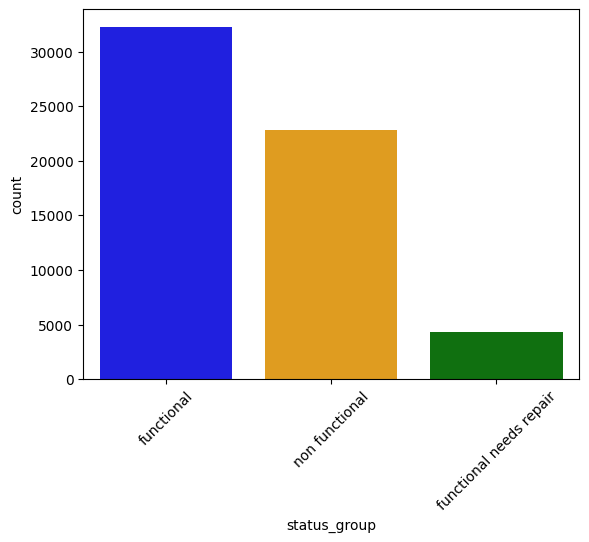

In [16]:
# sns.formatplot('status_group', data=train_labels_df, aspect=2, kind='count');
colores = ['blue', 'orange', 'green']

# Suponiendo que 'train_labels_df' es tu DataFrame y 'status_group' la columna con categorías
sns.countplot(x='status_group', data=train_labels, palette=colores)
plt.xticks(rotation=45)  # Rota las etiquetas del eje X para mejor visualización si es necesario
plt.show()

Del gráfico anterior, es fácil ver que nuestro conjunto de datos está desbalanceado. Es importante mencionar que los árboles de decisión y los bosques aleatorios son extremadamente sensibles a los datos desequilibrados por lo que trataremos este problema más adelante.

## Unimos el dataset train_values y train_labels

In [17]:
# Unimos los dataset
train_labels.drop(columns=['id'],inplace=True)
train_values.drop(columns=['id'],inplace=True)

In [18]:
joined_df = train_values.join(train_labels)
print(joined_df.shape)

(59400, 40)


In [19]:
#Descargo el dataframe obtenido para inspeccionarlo con ¡¡POWERBI!!
with open('datos_train.csv', 'w') as f:
  joined_df.to_csv(f,  index = False)

files.download('datos_train.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Limpieza de datos**

In [20]:
# Comprobamos los duplicados
joined_df.duplicated().sum()

36

In [21]:
# Eliminamos los duplicados
joined_df=joined_df.drop_duplicates()

### Valores nulos

In [22]:
# Contamos NAs por columna
joined_df.isnull().sum()

amount_tsh                   0
date_recorded                0
funder                    3637
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     2
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3314
recorded_by                  0
scheme_management         3878
scheme_name              28783
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_group                0
quantity

## **Manejo de valores perdidos y Outliers**

In [23]:
# funder
# Rellenamos los valores nulos con other
joined_df.funder.fillna('other', inplace=True)

# y también todos los valores con errores claros (1, A, M, N, ...)
joined_df.loc[joined_df.funder.str.len() == 1, 'funder'] = 'other'

In [24]:
# installer
# Rellenamos los valores nulos con other
joined_df.installer.fillna('other', inplace=True)

# y también todos los valores con errores claros (1, A, M, N, ...)
joined_df.loc[joined_df.installer.str.len() == 1, 'installer'] = 'other'

In [25]:
#  wpt_name
joined_df.groupby(['wpt_name']).size().sort_values(ascending=False)

wpt_name
none               3561
Shuleni            1748
Zahanati            830
Msikitini           535
Kanisani            323
                   ... 
Kwa Kinyama           1
Kwa Kinyaga           1
Kwa Kinyabi           1
Kwa Kinung'A          1
Kwa Mzee Lugaba       1
Length: 37399, dtype: int64

In [26]:
# Demasiados valores nan, borramos la columna
# joined_df = joined_df.drop('wpt_name', axis=1)

In [27]:
# Rellenamos los valores nan con other
joined_df.subvillage.fillna(value='other', inplace=True)

# y también todos los valores con errores claros (1, A, M, N, ...)
joined_df.loc[joined_df.subvillage.str.len() == 1, 'subvillage'] = 'other'

In [28]:
#  Public meeting
joined_df.groupby(['public_meeting']).size()

public_meeting
False     5054
True     50996
dtype: int64

In [29]:
# Ajustamos a True 1 y False 0
joined_df.loc[joined_df.public_meeting == True, 'public_meeting'] = 1
joined_df.loc[joined_df.public_meeting == False, 'public_meeting'] = 0

# convertimos la columna a entero
joined_df.public_meeting = joined_df.public_meeting.astype('int', errors='ignore')

# La relación True:false is 10:1, podemos poner todos los NAs como True
joined_df.public_meeting.fillna(1, inplace=True)
joined_df.public_meeting.isnull().sum()

0

In [30]:
# Management

# Rellenamos los valores NAs con other
joined_df.scheme_management.fillna('other', inplace=True)
joined_df.scheme_management.isnull().sum()

0

In [31]:
#  Scheme management
joined_df.groupby(['scheme_management']).size().sort_values(ascending=False)[:10]

scheme_management
VWC                 36779
WUG                  5186
other                3878
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1678
Private operator     1063
Company              1061
Other                 766
dtype: int64

In [32]:
# Scheme name
joined_df.groupby(['scheme_name']).size().sort_values(ascending=False)[:10]

scheme_name
K                              682
Borehole                       545
Chalinze wate                  405
M                              400
DANIDA                         379
Government                     320
Ngana water supplied scheme    270
wanging'ombe water supply s    261
wanging'ombe supply scheme     234
I                              229
dtype: int64

In [33]:
joined_df.groupby(['scheme_management','scheme_name']).size()[:10]

scheme_management  scheme_name              
Company            BFFS                           1
                   Bagamoyo Wate                 60
                   Bagamoyo wate                210
                   Borehole                       1
                   Borehole drilling project      1
                   Bulamba piped scheme           2
                   Burieni water supply           1
                   Doe water supply               3
                   EKTM 2 water  supply           1
                   EKTM 2 water suply            25
dtype: int64

In [34]:
joined_df.groupby(['scheme_management','management']).size()[:10]

scheme_management  management      
Company            company             674
                   other                 2
                   parastatal           25
                   private operator    224
                   vwc                 135
                   wug                   1
Other              other               519
                   parastatal            1
                   private operator     64
                   trust                 1
dtype: int64

In [35]:
# Borramos la columna scheme_name, demasiados niveles
# joined_df = joined_df.drop('scheme_name', axis=1)

In [36]:
# permit
joined_df.groupby(['permit'])['status_group'].count().sort_values(ascending=False)

permit
True     38838
False    17470
Name: status_group, dtype: int64

In [37]:
# Borramos la columna
# joined_df = joined_df.drop('permit', axis=1)

### Estadística Descriptiva

In [38]:
joined_df.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,6000.00,2011-03-14,Roman,1390,Roman,34.94,-9.86,none,0,Lake Nyasa,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,0.00,2013-03-06,Grumeti,1399,GRUMETI,34.70,-2.15,Zahanati,0,Lake Victoria,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,25.00,2013-02-25,Lottery Club,686,World vision,37.46,-3.82,Kwa Mahundi,0,Pangani,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,0.00,2013-01-28,Unicef,263,UNICEF,38.49,-11.16,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,0.00,2011-07-13,Action In A,0,Artisan,31.13,-1.83,Shuleni,0,Lake Victoria,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [39]:
joined_df.describe()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,public_meeting,construction_year
count,59364.00,59364.00,59364.00,59364.00,59364.00,59364.00,59364.00,59364.00,59364.00,59364.00
mean,317.84,668.70,34.10,-5.71,0.47,15.30,5.63,180.02,0.91,1301.44
std,2998.47,693.13,6.52,2.94,12.24,17.59,9.64,471.60,0.28,951.37
min,0.00,-90.00,0.00,-11.65,0.00,1.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,33.10,-8.54,0.00,5.00,2.00,0.00,1.00,0.00
50%,0.00,370.00,34.91,-5.02,0.00,12.00,3.00,25.00,1.00,1986.00
75%,20.00,1320.00,37.18,-3.33,0.00,17.00,5.00,215.00,1.00,2004.00
max,350000.00,2770.00,40.35,-0.00,1776.00,99.00,80.00,30500.00,1.00,2013.00


Con estas tablas podemos comprobar la distribución de los datos. Observamos que hay varios valores faltantes para los *min* de las variables. Esto se refiere a la existencia de valores *missing* que tendremos que tratar antes de seguir con los modelos.

## **Distribución de Datos**

Ya habíamos visto que los datos están desbalanceados por eso vamos a estudiar la distribución de la variable objetivo *status_group* en *joined_df* que nos servirá para los cálculos de nuestras predicciones.

<Axes: xlabel='label'>

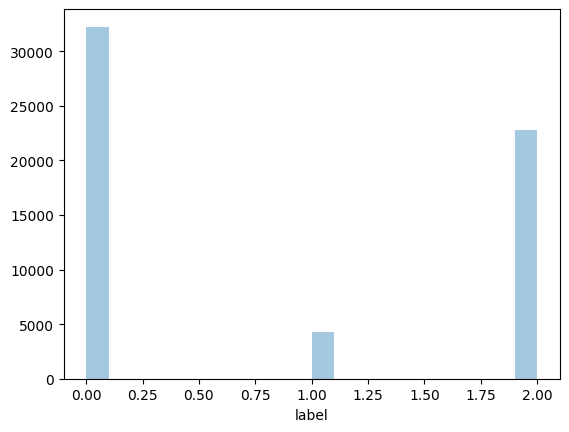

In [40]:
label_dict = {"functional":0,"functional needs repair":1,"non functional":2}
joined_df["label"] = joined_df["status_group"].map(label_dict)
sns.distplot(joined_df["label"],kde=False)

In [41]:
majority_class = joined_df['status_group'].mode()[0]
print("La etiqueta con mayor frecuencia es", majority_class)

y_prelim_pred = np.full(shape=joined_df['status_group'].shape, fill_value=majority_class)
accuracy_score(joined_df['status_group'], y_prelim_pred)

La etiqueta con mayor frecuencia es functional


0.5430395525907957

Significa que podemos empezar a hacer una estimación del 54.31% de probabilidad de que una bomba cualquiera de esta base de datos funcione bien (es decir, sea *functional*). Esto nos sirve de base para futuras predicciones.

Dado que nuestra variable objetivo es discreta, necesitaremos un algoritmo de clasificación supervisada, que son los que aplicaremos más adelante

## Histogramas de todas las características

array([[<Axes: title={'center': 'amount_tsh'}>,
        <Axes: title={'center': 'date_recorded'}>,
        <Axes: title={'center': 'funder'}>,
        <Axes: title={'center': 'gps_height'}>,
        <Axes: title={'center': 'installer'}>,
        <Axes: title={'center': 'longitude'}>],
       [<Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'wpt_name'}>,
        <Axes: title={'center': 'num_private'}>,
        <Axes: title={'center': 'basin'}>,
        <Axes: title={'center': 'subvillage'}>,
        <Axes: title={'center': 'region'}>],
       [<Axes: title={'center': 'region_code'}>,
        <Axes: title={'center': 'district_code'}>,
        <Axes: title={'center': 'lga'}>,
        <Axes: title={'center': 'ward'}>,
        <Axes: title={'center': 'population'}>,
        <Axes: title={'center': 'public_meeting'}>],
       [<Axes: title={'center': 'recorded_by'}>,
        <Axes: title={'center': 'scheme_management'}>,
        <Axes: title={'center': 'scheme_name'}>,


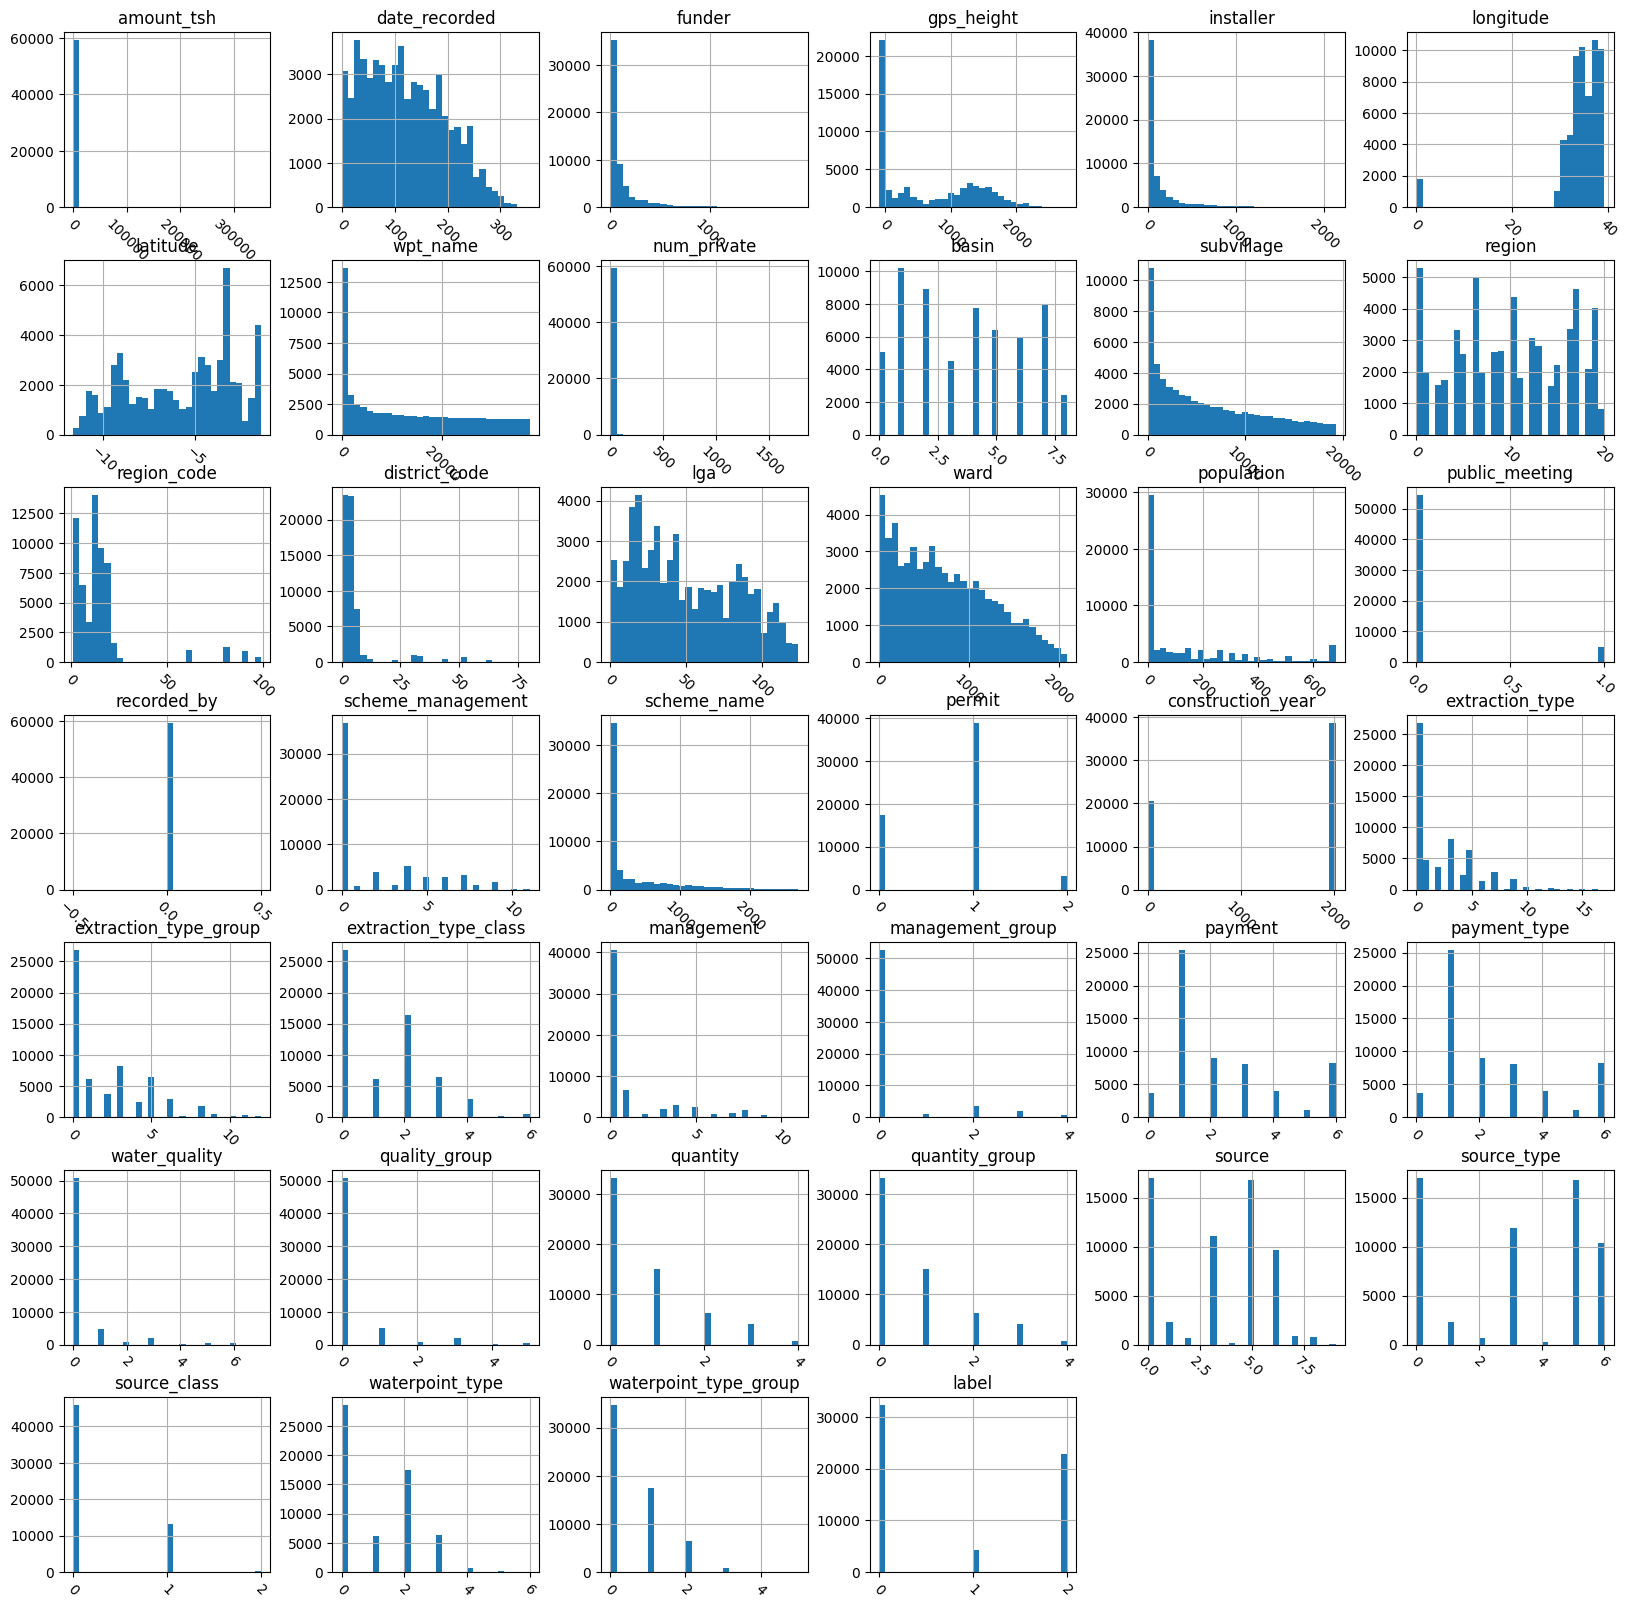

In [75]:
joined_df.hist(figsize=(20,20), bins = 30, xrot=-45 ,)

## Variables numéricas

In [42]:
numerical_vars = joined_df.select_dtypes(exclude='object')
numeric_cols = numerical_vars.columns.tolist() # Columnas numéricas en el dataset
print(numeric_cols)

['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'public_meeting', 'construction_year', 'label']


## Analizamos las columnas numéricas

## *amount_tsh*
Esta variable muestra la cantidad de agua que queda en un pozo. Podría ser útil a la hora de predecir si su respectiva bomba funciona o no.

<Axes: xlabel='status_group', ylabel='amount_tsh'>

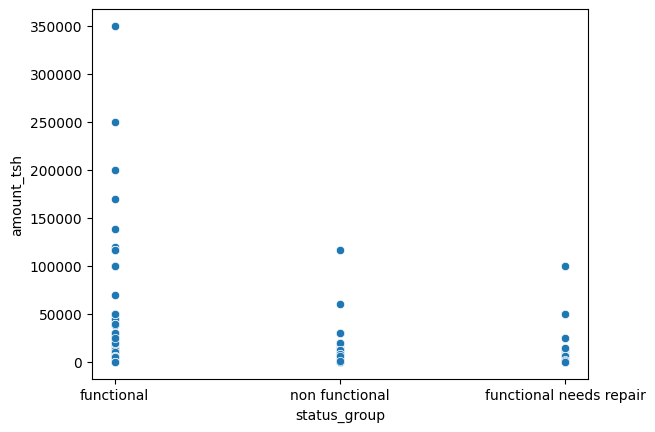

In [43]:
sns.scatterplot(y=joined_df["amount_tsh"],x=joined_df["status_group"])

Si amount_tsh es mayor de 150000, lo más probable es que la bomba funcione.

<Axes: xlabel='status_group', ylabel='gps_height'>

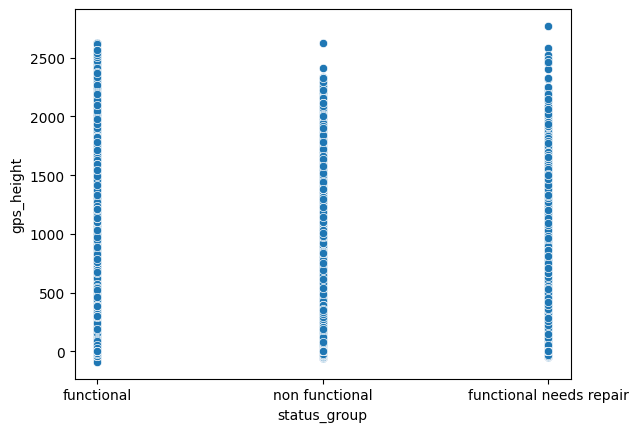

In [44]:
sns.scatterplot(y=joined_df["gps_height"],x=joined_df["status_group"])

<Axes: xlabel='status_group', ylabel='population'>

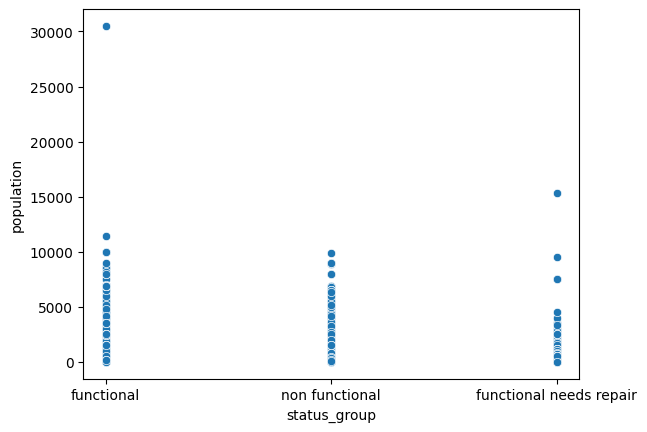

In [45]:
sns.scatterplot(y=joined_df["population"],x=joined_df["status_group"])

<Axes: xlabel='status_group', ylabel='longitude'>

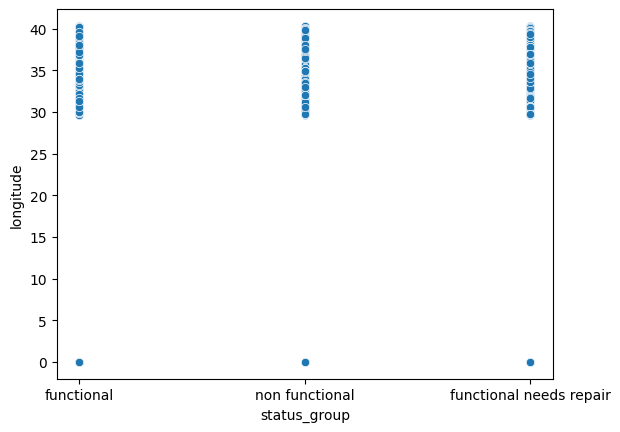

In [46]:
sns.scatterplot(y=joined_df["longitude"],x=joined_df["status_group"])

<Axes: xlabel='status_group', ylabel='latitude'>

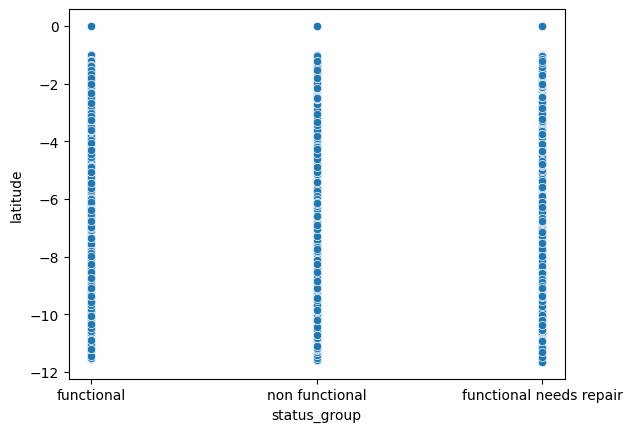

In [47]:
sns.scatterplot(y=joined_df["latitude"],x=joined_df["status_group"])

<Axes: xlabel='status_group', ylabel='construction_year'>

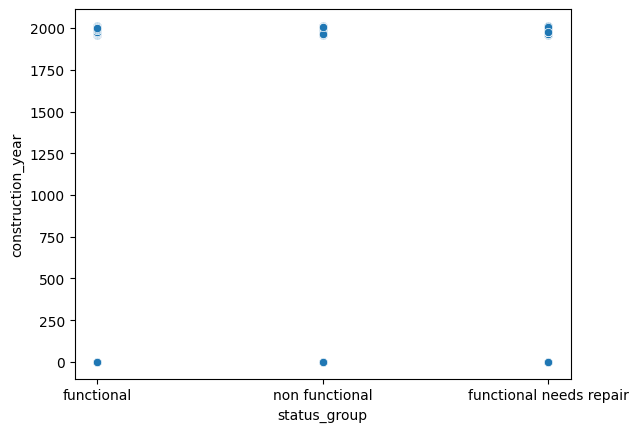

In [48]:
sns.scatterplot(y=joined_df["construction_year"],x=joined_df["status_group"])

 ## *construction_year*
 Vamos a realizar un gráfico de esta variable y el número de bombas construidas en ese año.

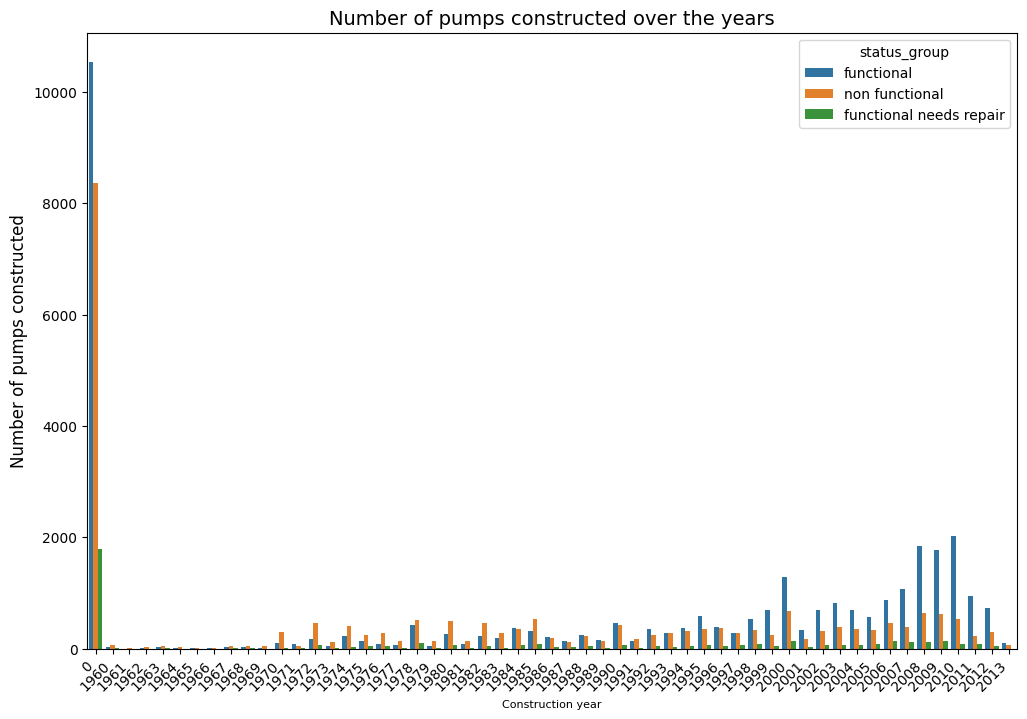

In [49]:
# Ajustando el tamaño de la figura
plt.figure(figsize=(12, 8))

sns.countplot(x=joined_df["construction_year"],hue=joined_df["status_group"])
plt.xticks(rotation=45,
    horizontalalignment='right')
plt.title("Number of pumps constructed over the years", fontsize=14)
plt.xlabel("Construction year", fontsize=8)
plt.ylabel("Number of pumps constructed", fontsize=12)


# Mostrando el gráfico
plt.show()


Observamos que la mayoría de las que fueron construidas hasta el año 1985 no funcionan, mientras que las más recientes sí. Esto significa que este atributo puede ser muy útil a la hora de realizar las predicciones en nuestro modelo. El número de bombas que necesitan una reparación no parece muy elevado y sobretodo se mantiene estable con el paso de los años. Las filas que tienen un cero como año de construcción deberían revisarse.

## Distribución de variables numéricas

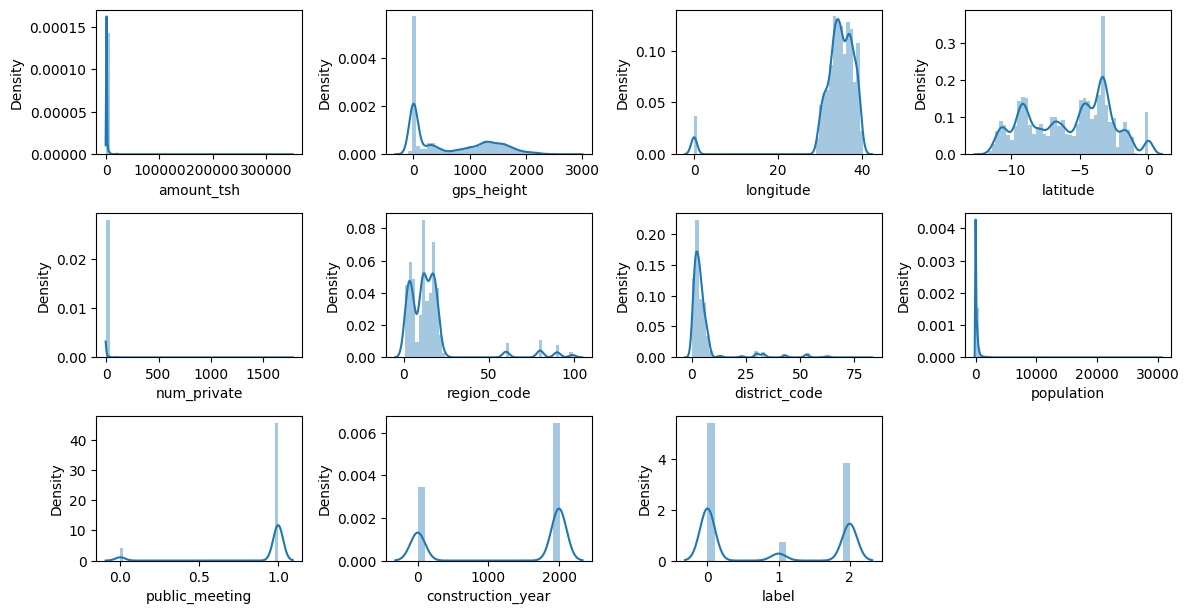

In [50]:
fig = plt.figure(figsize=(12,18))
sns.distributions._has_statsmodels=False
for i in range(len(numeric_cols)):
    fig.add_subplot(9,4,i+1)
    sns.distplot(joined_df[numeric_cols].iloc[:,i].dropna())
    plt.xlabel(numeric_cols[i])

plt.tight_layout()
plt.show()

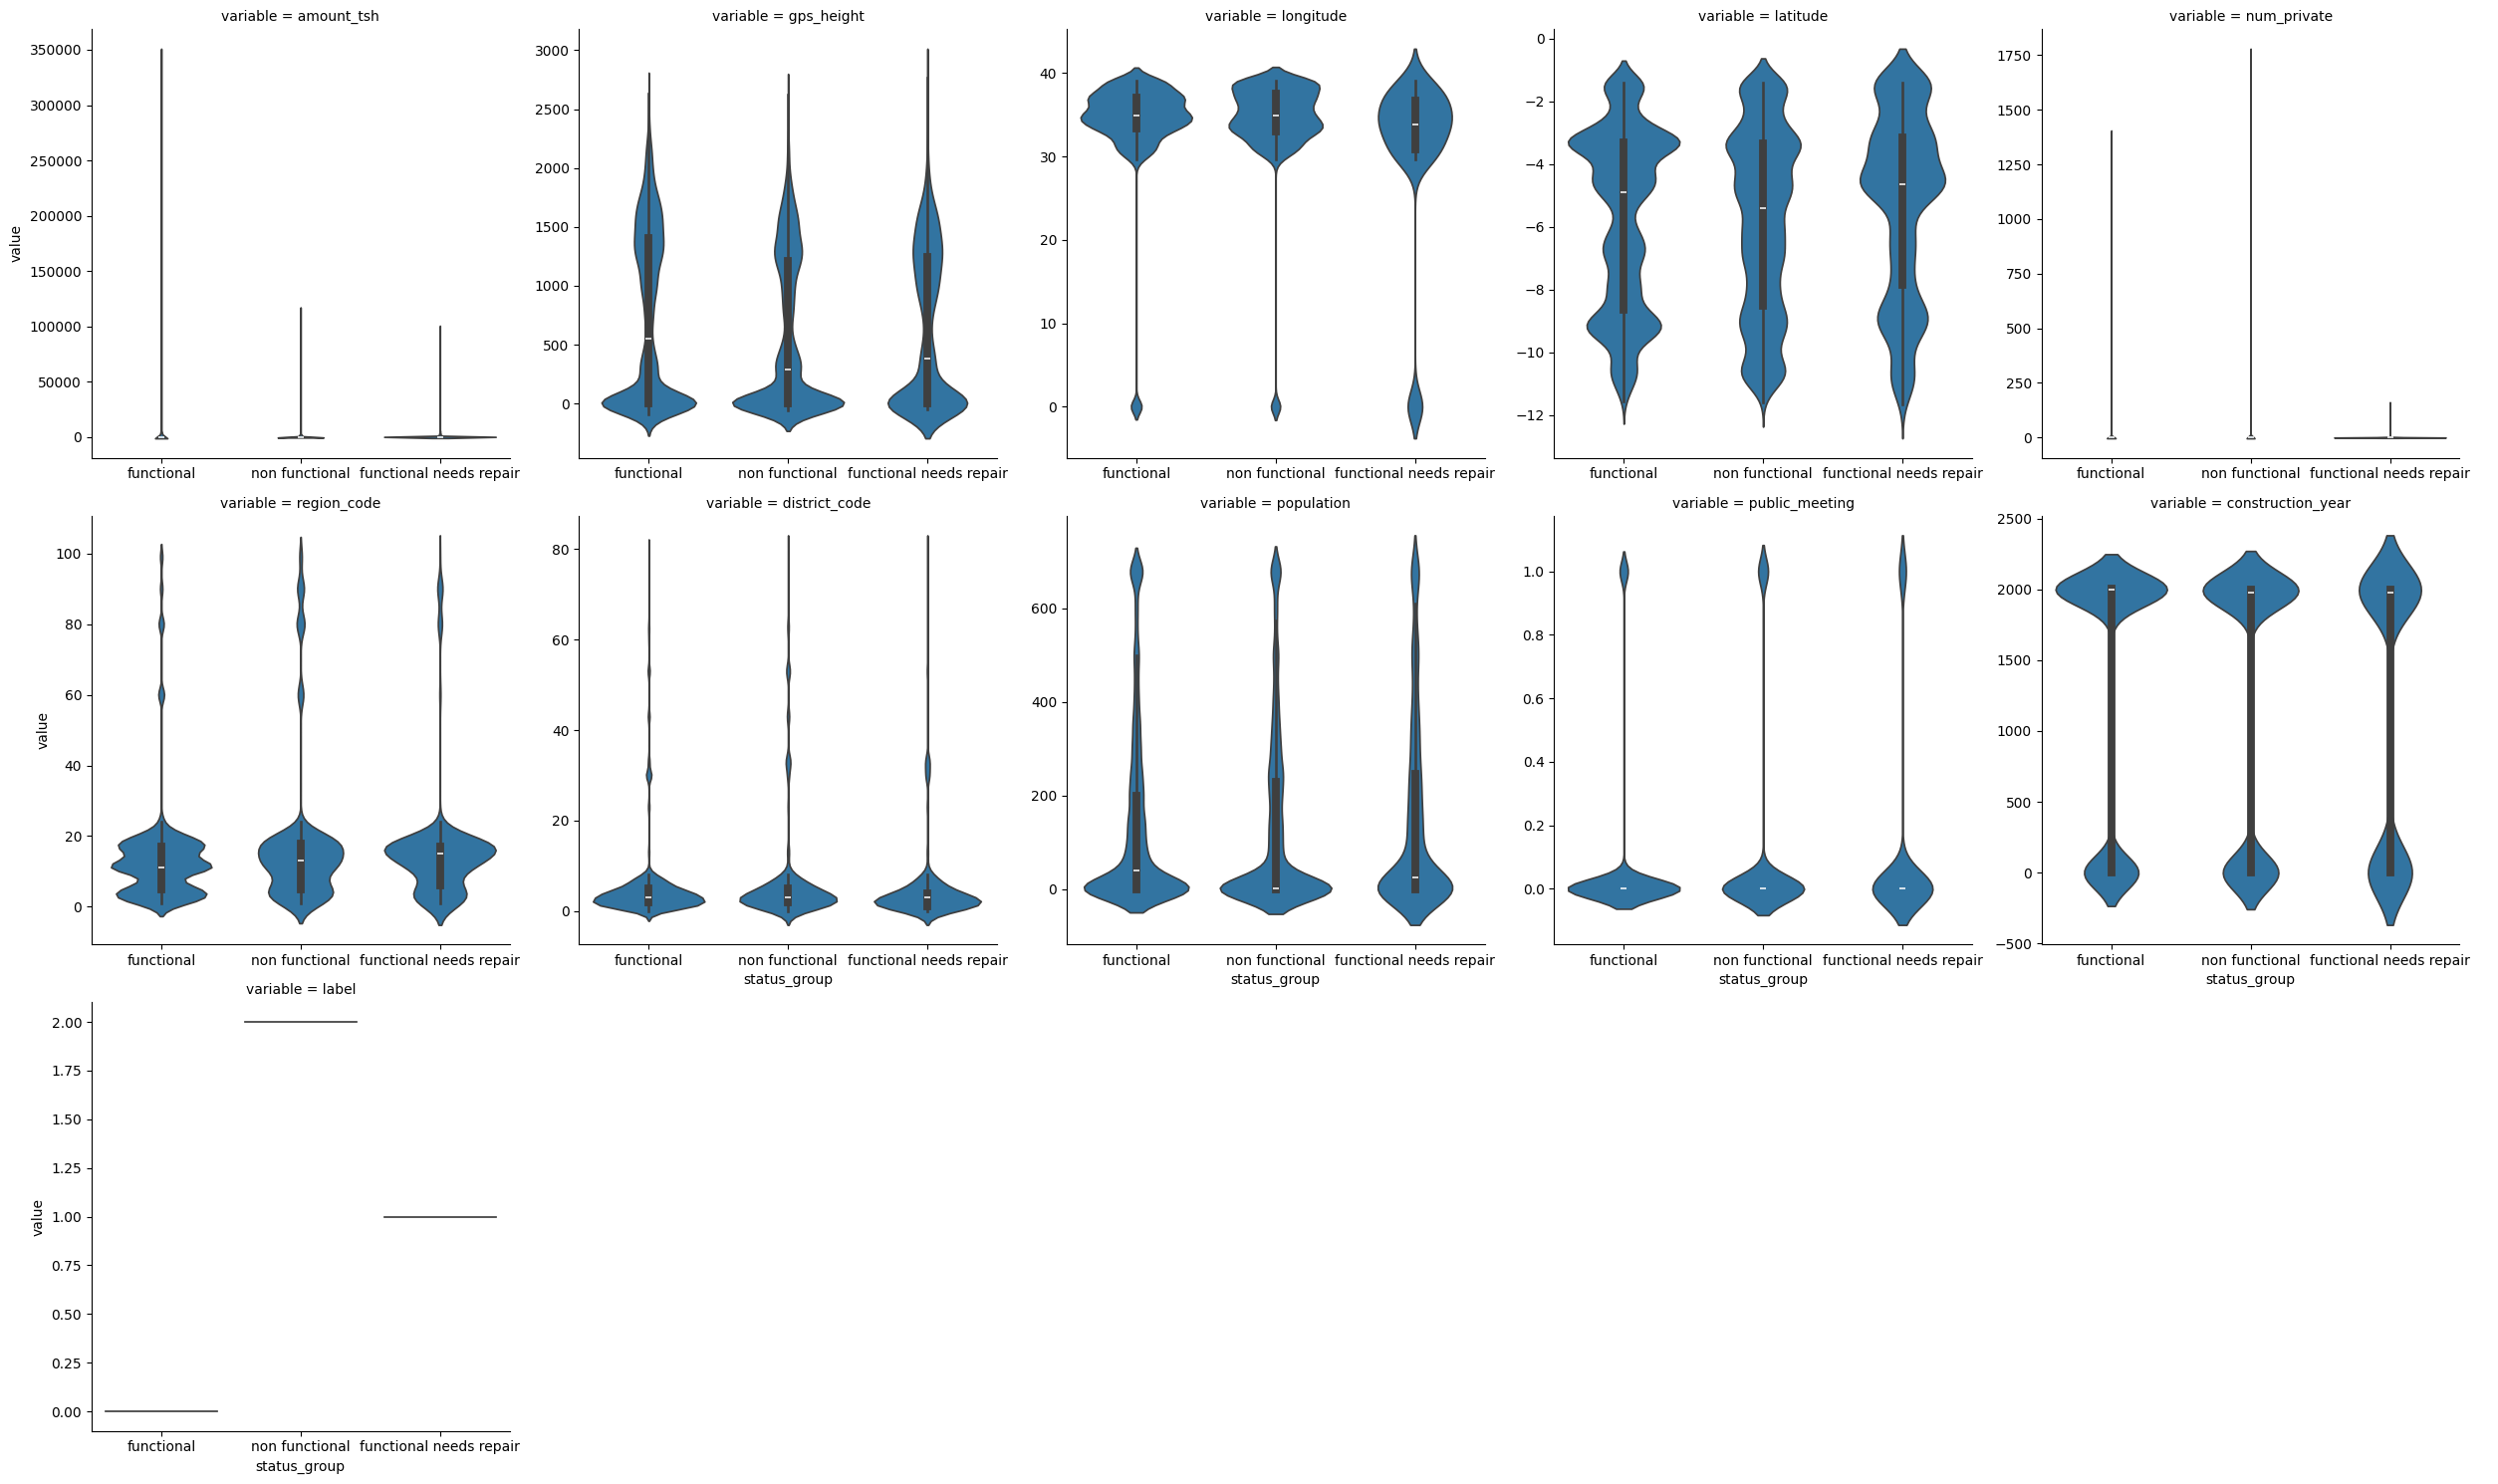

In [76]:
f = pd.melt( joined_df[numeric_cols+["status_group"]], id_vars='status_group', value_vars=numeric_cols)

g = sns.catplot(x="status_group" , y="value",
                col="variable",col_wrap=5,
                data=f, kind="violin",sharey=False,sharex=False);

## **Outliers**

La visualización de los datos hace sospechar la posible existencia de valores atípicos o *outliers* en nuestros datos

Análisis univariante: diagramas de caja para atributos numéricos

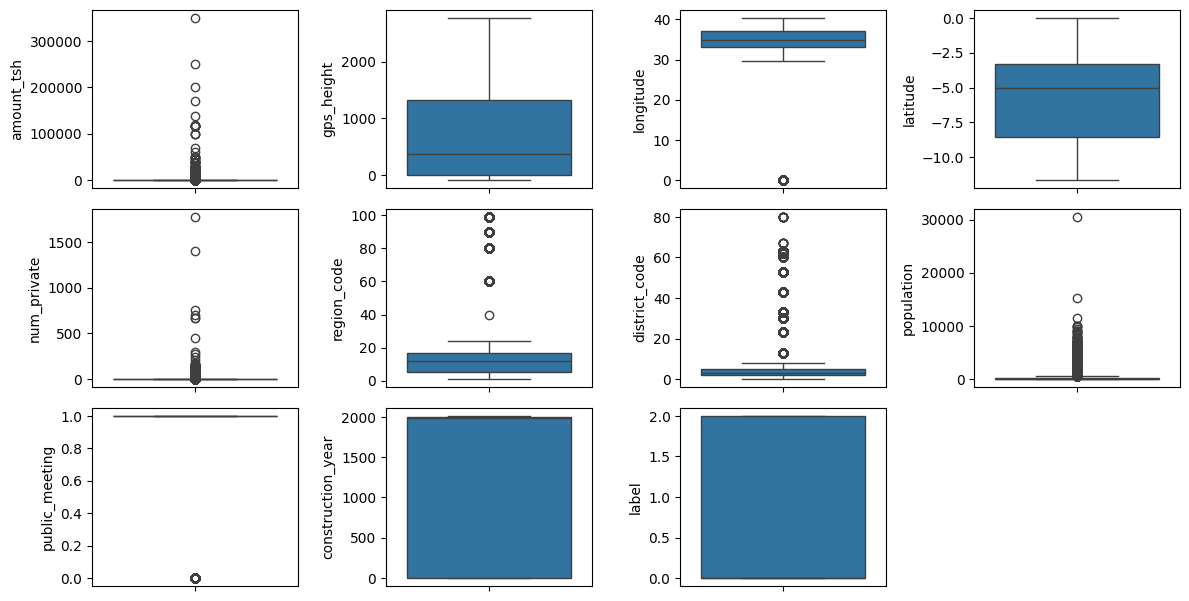

In [51]:
fig = plt.figure(figsize=(12, 18))

for i in range(len(numeric_cols)):
    fig.add_subplot(9, 4, i+1)
    sns.boxplot(y=joined_df[numeric_cols].iloc[:,i])

plt.tight_layout()
plt.show()

Hay una gran cantidad de valores 0 para **amount_tsh, gps_height, num private, longitude, construction year, population, longitude** . Esto tiene sentido para **gps_height** ( 0 significa a nivel del mar) y **amount_tsh**, pero no tiene sentido para las otras columnas.
Encontramos valores outliers, por ejemplo, en  *population* , *longitude* y *latitude*.

Análisis de datos bivariantes: diagramas de dispersión para el objetivo frente a los atributos numéricos

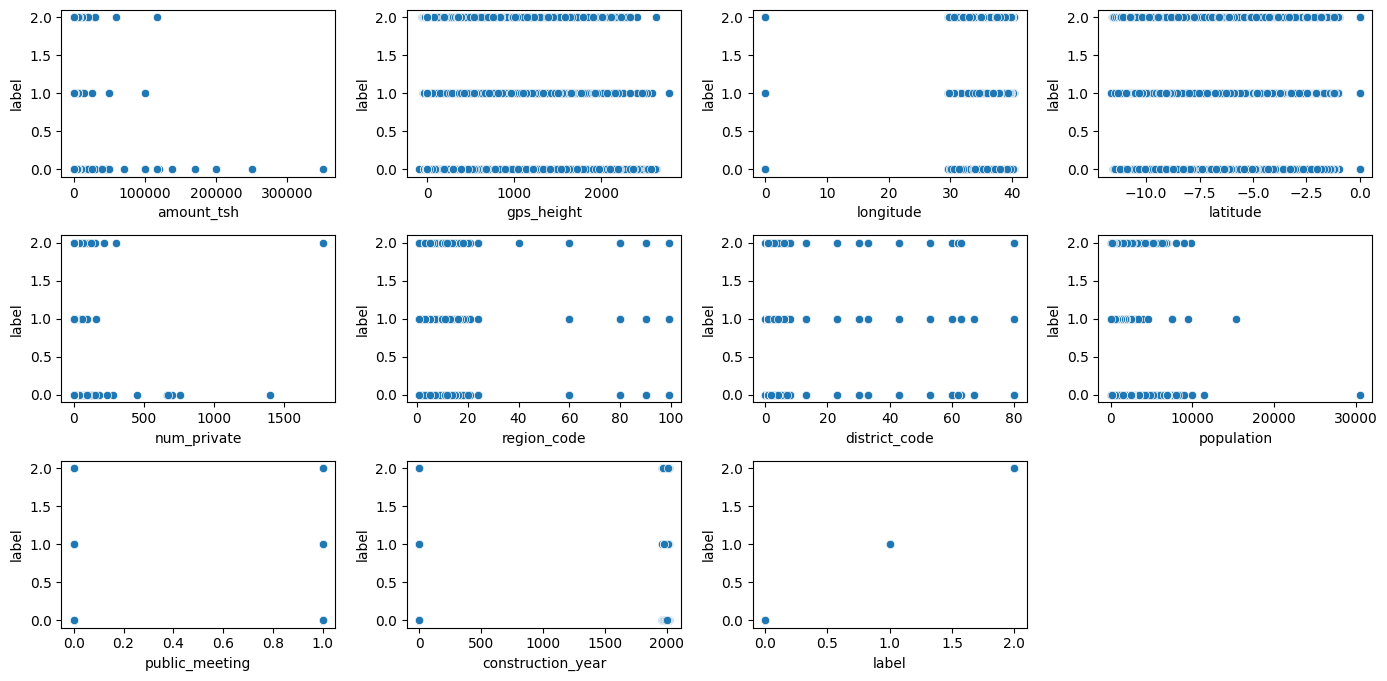

In [52]:
figure = plt.figure(figsize=(14,20))

for i in range(len(numeric_cols)):
    ax = figure.add_subplot(9, 4, i+1)
    sns.scatterplot(x=joined_df[numeric_cols[i]], y=joined_df["label"], ax=ax)

plt.tight_layout()
plt.show()


Aplicamos **Winsorization** al dataset usando la **función winsorize** del módulo scipy.stats.mstats. La Winsorización es un método estadístico que se aplica a un conjunto de datos para limitar valores extremos y reducir el efecto de los valores atípicos.

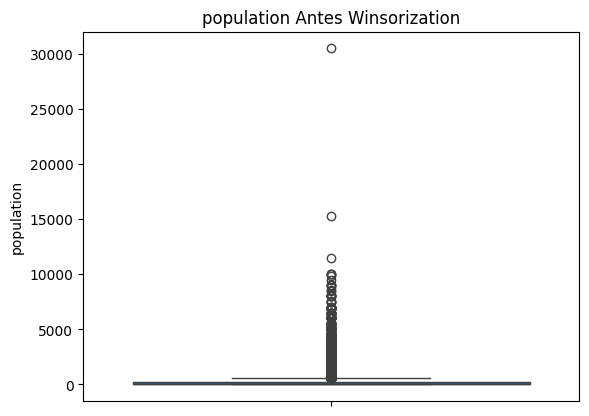

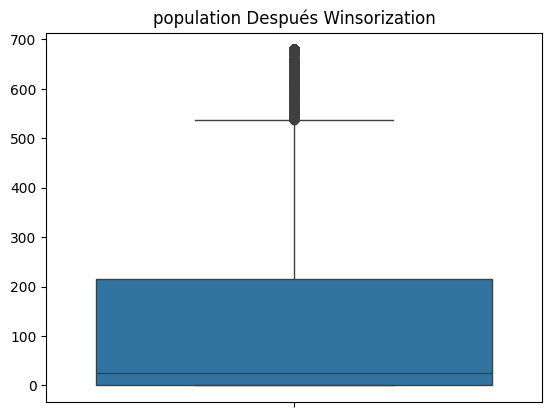

In [53]:
# Inicialización de la Fuente de Datos
name = "population"
data = joined_df[name]

# Visualización de Datos Antes de la Winsorización:
sns.boxplot(data)  # Un diagrama de caja muestra visualmente la distribución de los datos, incluyendo la mediana, cuartiles y posibles valores atípicos.
plt.title("{} Antes Winsorization".format(name))
plt.show()

# Aplicamos Winsorización
winsorized_data = winsorize(data,(0, 0.05))
# La función winsorize se utiliza para aplicar la Winsorización a los datos. La tupla (0, 0.05) como segundo argumento indica que la función debe limitar el 5% superior de los datos.
# El valor 0 significa que no hay limitación en el extremo inferior (no se ajustan los valores más pequeños).
# Esta función reemplaza todos los puntos de datos por encima del percentil 95 con el valor en el percentil 95.

# Después winsorización
sns.boxplot(winsorized_data)
plt.title("{} Después Winsorization".format(name))
plt.show()

# Reemplazo de Datos en el Conjunto de Datos
joined_df[name] = winsorized_data

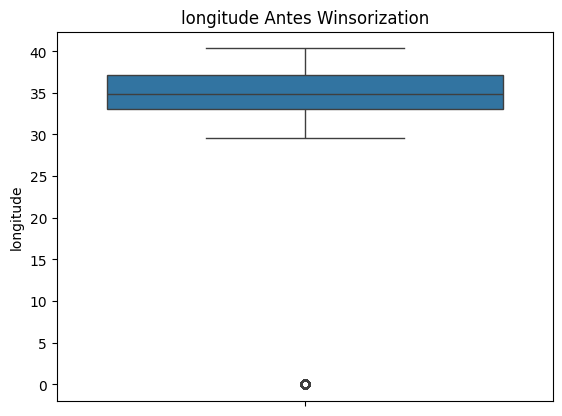

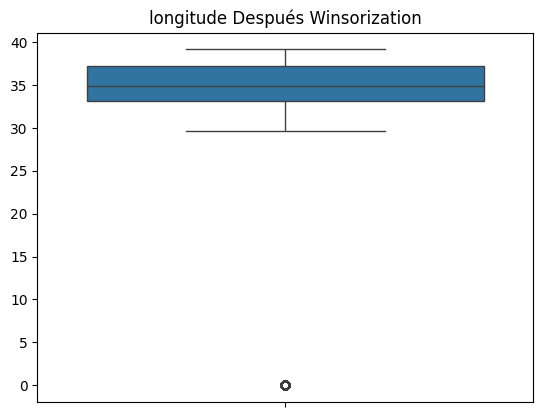

In [54]:
# Inicialización de la Fuente de Datos
name = "longitude"
data = joined_df[name]

# Visualización de Datos Antes de la Winsorización:
sns.boxplot(data)  # Un diagrama de caja muestra visualmente la distribución de los datos, incluyendo la mediana, cuartiles y posibles valores atípicos.
plt.title("{} Antes Winsorization".format(name))
plt.show()

# Aplicamos Winsorización
winsorized_data = winsorize(data,(0, 0.05))
# La función winsorize se utiliza para aplicar la Winsorización a los datos. La tupla (0, 0.05) como segundo argumento indica que la función debe limitar el 5% superior de los datos.
# El valor 0 significa que no hay limitación en el extremo inferior (no se ajustan los valores más pequeños).
# Esta función reemplaza todos los puntos de datos por encima del percentil 95 con el valor en el percentil 95.

# Después winsorización
sns.boxplot(winsorized_data)
plt.title("{} Después Winsorization".format(name))
plt.show()

# Reemplazo de Datos en el Conjunto de Datos
joined_df[name] = winsorized_data

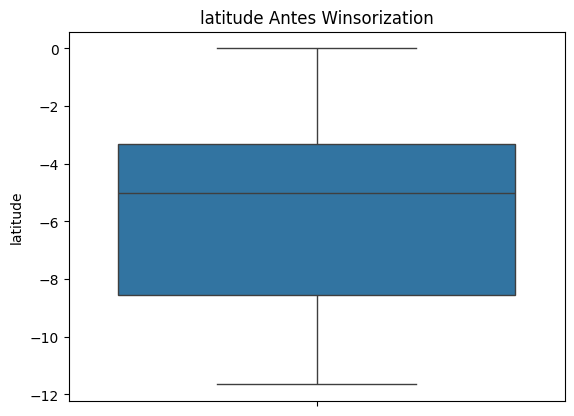

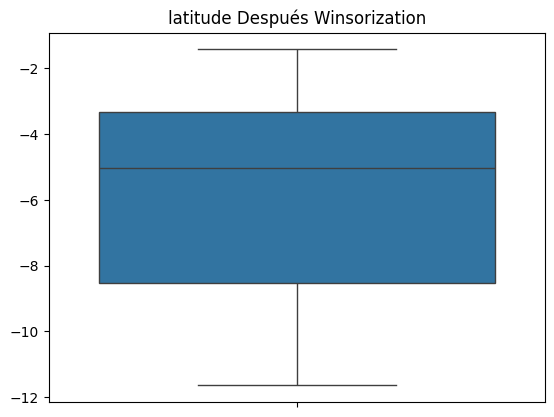

In [55]:
# Inicialización de la Fuente de Datos
name = "latitude"
data = joined_df[name]

# Visualización de Datos Antes de la Winsorización:
sns.boxplot(data)  # Un diagrama de caja muestra visualmente la distribución de los datos, incluyendo la mediana, cuartiles y posibles valores atípicos.
plt.title("{} Antes Winsorization".format(name))
plt.show()

# Aplicamos Winsorización
winsorized_data = winsorize(data,(0, 0.05))
# La función winsorize se utiliza para aplicar la Winsorización a los datos. La tupla (0, 0.05) como segundo argumento indica que la función debe limitar el 5% superior de los datos.
# El valor 0 significa que no hay limitación en el extremo inferior (no se ajustan los valores más pequeños).
# Esta función reemplaza todos los puntos de datos por encima del percentil 95 con el valor en el percentil 95.

# Después winsorización
sns.boxplot(winsorized_data)
plt.title("{} Después Winsorization".format(name))
plt.show()

# Reemplazo de Datos en el Conjunto de Datos
joined_df[name] = winsorized_data

Finalmente, los datos de *population*, *longitude* y *latitude* en el DataFrame se reemplazan con los datos winsorizados. Este paso modifica el conjunto de datos original con los datos ajustados, que ahora son menos susceptibles a la influencia de valores atípicos en el extremo superior.

Este procedimiento demuestra efectivamente cómo preprocesar datos limitando valores extremos para hacer el análisis estadístico subsiguiente más robusto y confiable. La Winsorización es especialmente útil en conjuntos de datos donde los valores extremos pueden sesgar los resultados.

## Variables categóricas

In [56]:
cat_vars = joined_df.select_dtypes(include='object')
object_cols = cat_vars.columns.tolist() # Columnas string en el dataset
print(object_cols)

['date_recorded', 'funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region', 'lga', 'ward', 'recorded_by', 'scheme_management', 'scheme_name', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group', 'status_group']


In [57]:
# --- Date recorded: fecha en la que se insertó la fila ---


#joined_df.date_recorded[:10]

In [58]:
# dividimos en año y mes
#joined_df['year_recorded'] = joined_df.date_recorded.str.slice(0,4)
#joined_df['month_recorded'] = joined_df.date_recorded.str.slice(5,7)

# Convertimos a enteros
#joined_df.year_recorded = joined_df.year_recorded.astype('float', errors='ignore')
#joined_df.month_recorded = joined_df.month_recorded.astype('float', errors='ignore')

# y borramos la columna date_recorded
#joined_df = joined_df.drop('date_recorded', axis=1)

In [59]:
# Distribución
#sns.distplot(joined_df.year_recorded);

In [60]:
#joined_df.groupby(['year_recorded'])['status_group'].count()

In [61]:
# Suponemos que  2001, 2002 y 2004 son erróneos
#joined_df.loc[joined_df.year_recorded == 2001.0, 'year_recorded'] = 2011
#joined_df.loc[joined_df.year_recorded == 2002.0, 'year_recorded'] = 2012
#joined_df.loc[joined_df.year_recorded == 2004.0, 'year_recorded'] = 2014

In [62]:
# Nueva distribución
#sns.distplot(joined_df.year_recorded)

## **Factorización**

Listar las características categóricas: Se crea una lista llamada categorical que contiene los nombres de las columnas en el marco de datos joined_df que son consideradas características categóricas. Estas características probablemente son de tipo string o categoría y representan grupos o clasificaciones distintas en el conjunto de datos.

Bucle para factorizar las características categóricas: El bucle for recorre cada nombre de columna almacenado en la lista categorical. Para cada una de estas columnas:

Factorización: Se utiliza pd.factorize() de Pandas para convertir cada categoría única en un número entero único. La función pd.factorize() devuelve dos objetos:

Un array de índices, donde cada índice representa la categoría correspondiente como un entero.
Un índice o array con las etiquetas únicas.
En este código, solo se utiliza el array de índices (por eso se usa [0] después de pd.factorize()), que se asigna de nuevo a la columna original en el marco de datos joined_df.

Actualización del marco de datos: Cada columna categórica en joined_df es reemplazada por su versión factorizada, donde todas las categorías únicas han sido convertidas a números enteros. Esto es útil para modelos de machine learning que requieren entradas numéricas y no pueden manejar directamente formatos de texto o categorías.

Ejemplo Ilustrativo:
Si originalmente tenías una columna como basin con valores textuales como ["Nilo", "Amazonas", "Ganges"], después de aplicar pd.factorize(), estos podrían ser convertidos a [0, 1, 2], donde cada nombre del río está representado por un número entero único.

Importancia en Machine Learning:
La factorización (o codificación de etiquetas, en este caso) es esencial para preparar datos categóricos para algoritmos de aprendizaje automático, muchos de los cuales solo pueden manejar datos numéricos. Sin embargo, es importante notar que la codificación de etiquetas puede introducir un orden artificial (por ejemplo, Ganges > Amazonas > Nilo, lo que no tiene sentido real), lo cual puede ser problemático para algunos modelos, especialmente aquellos que asumen una relación ordinal entre los números (como los modelos lineales).

Este tipo de codificación es rápida y eficaz en términos de memoria, pero dependiendo del tipo de modelo y análisis, podrían ser más adecuadas otras técnicas de codificación, como One-Hot Encoding o Embeddings para modelos más complejos.

In [67]:
# BOrramos las columnas de menos uso
#joined_df = joined_df.drop(['id', 'subvillage', 'lga', 'ward'], axis=1)

# Listamos las características categóricas
categorical = ['date_recorded',
               'funder',
               'installer',
               'wpt_name',
               'basin',
               'subvillage',
                'region',
                'lga',
                'ward',
                'public_meeting',
               'recorded_by',
               'scheme_management',
               'scheme_name',
               'permit',
               'extraction_type',
               'extraction_type_group',
               'extraction_type_class',
               'management',
               'management_group',
               'payment',
               'payment_type',
               'water_quality',
               'quality_group',
               'quantity',
               'quantity_group',
               'source',
               'source_type',
               'source_class',
               'waterpoint_type',
               'waterpoint_type_group']

# And now factorize all the categorical features
for i in categorical:
    joined_df[i] = pd.factorize(joined_df[i])[0]

## Correlación entre variables

Para poder utilizar la regresión lineal es necesario quitar las variables que estén altamente correlacionadas para así mejorar el modelo.

A continuación se presenta el gráfico de correlación:

In [ ]:
#joined_df.corr()



In [ ]:
#mask = np.zeros_like(joined_df.corr(), dtype=np.bool)
#mask[np.triu_indices_from(mask)] = True
#plt.figure(figsize=(20,20))
#sns.heatmap(joined_df.corr(), cmap='RdBu_r', annot = True, mask = mask )

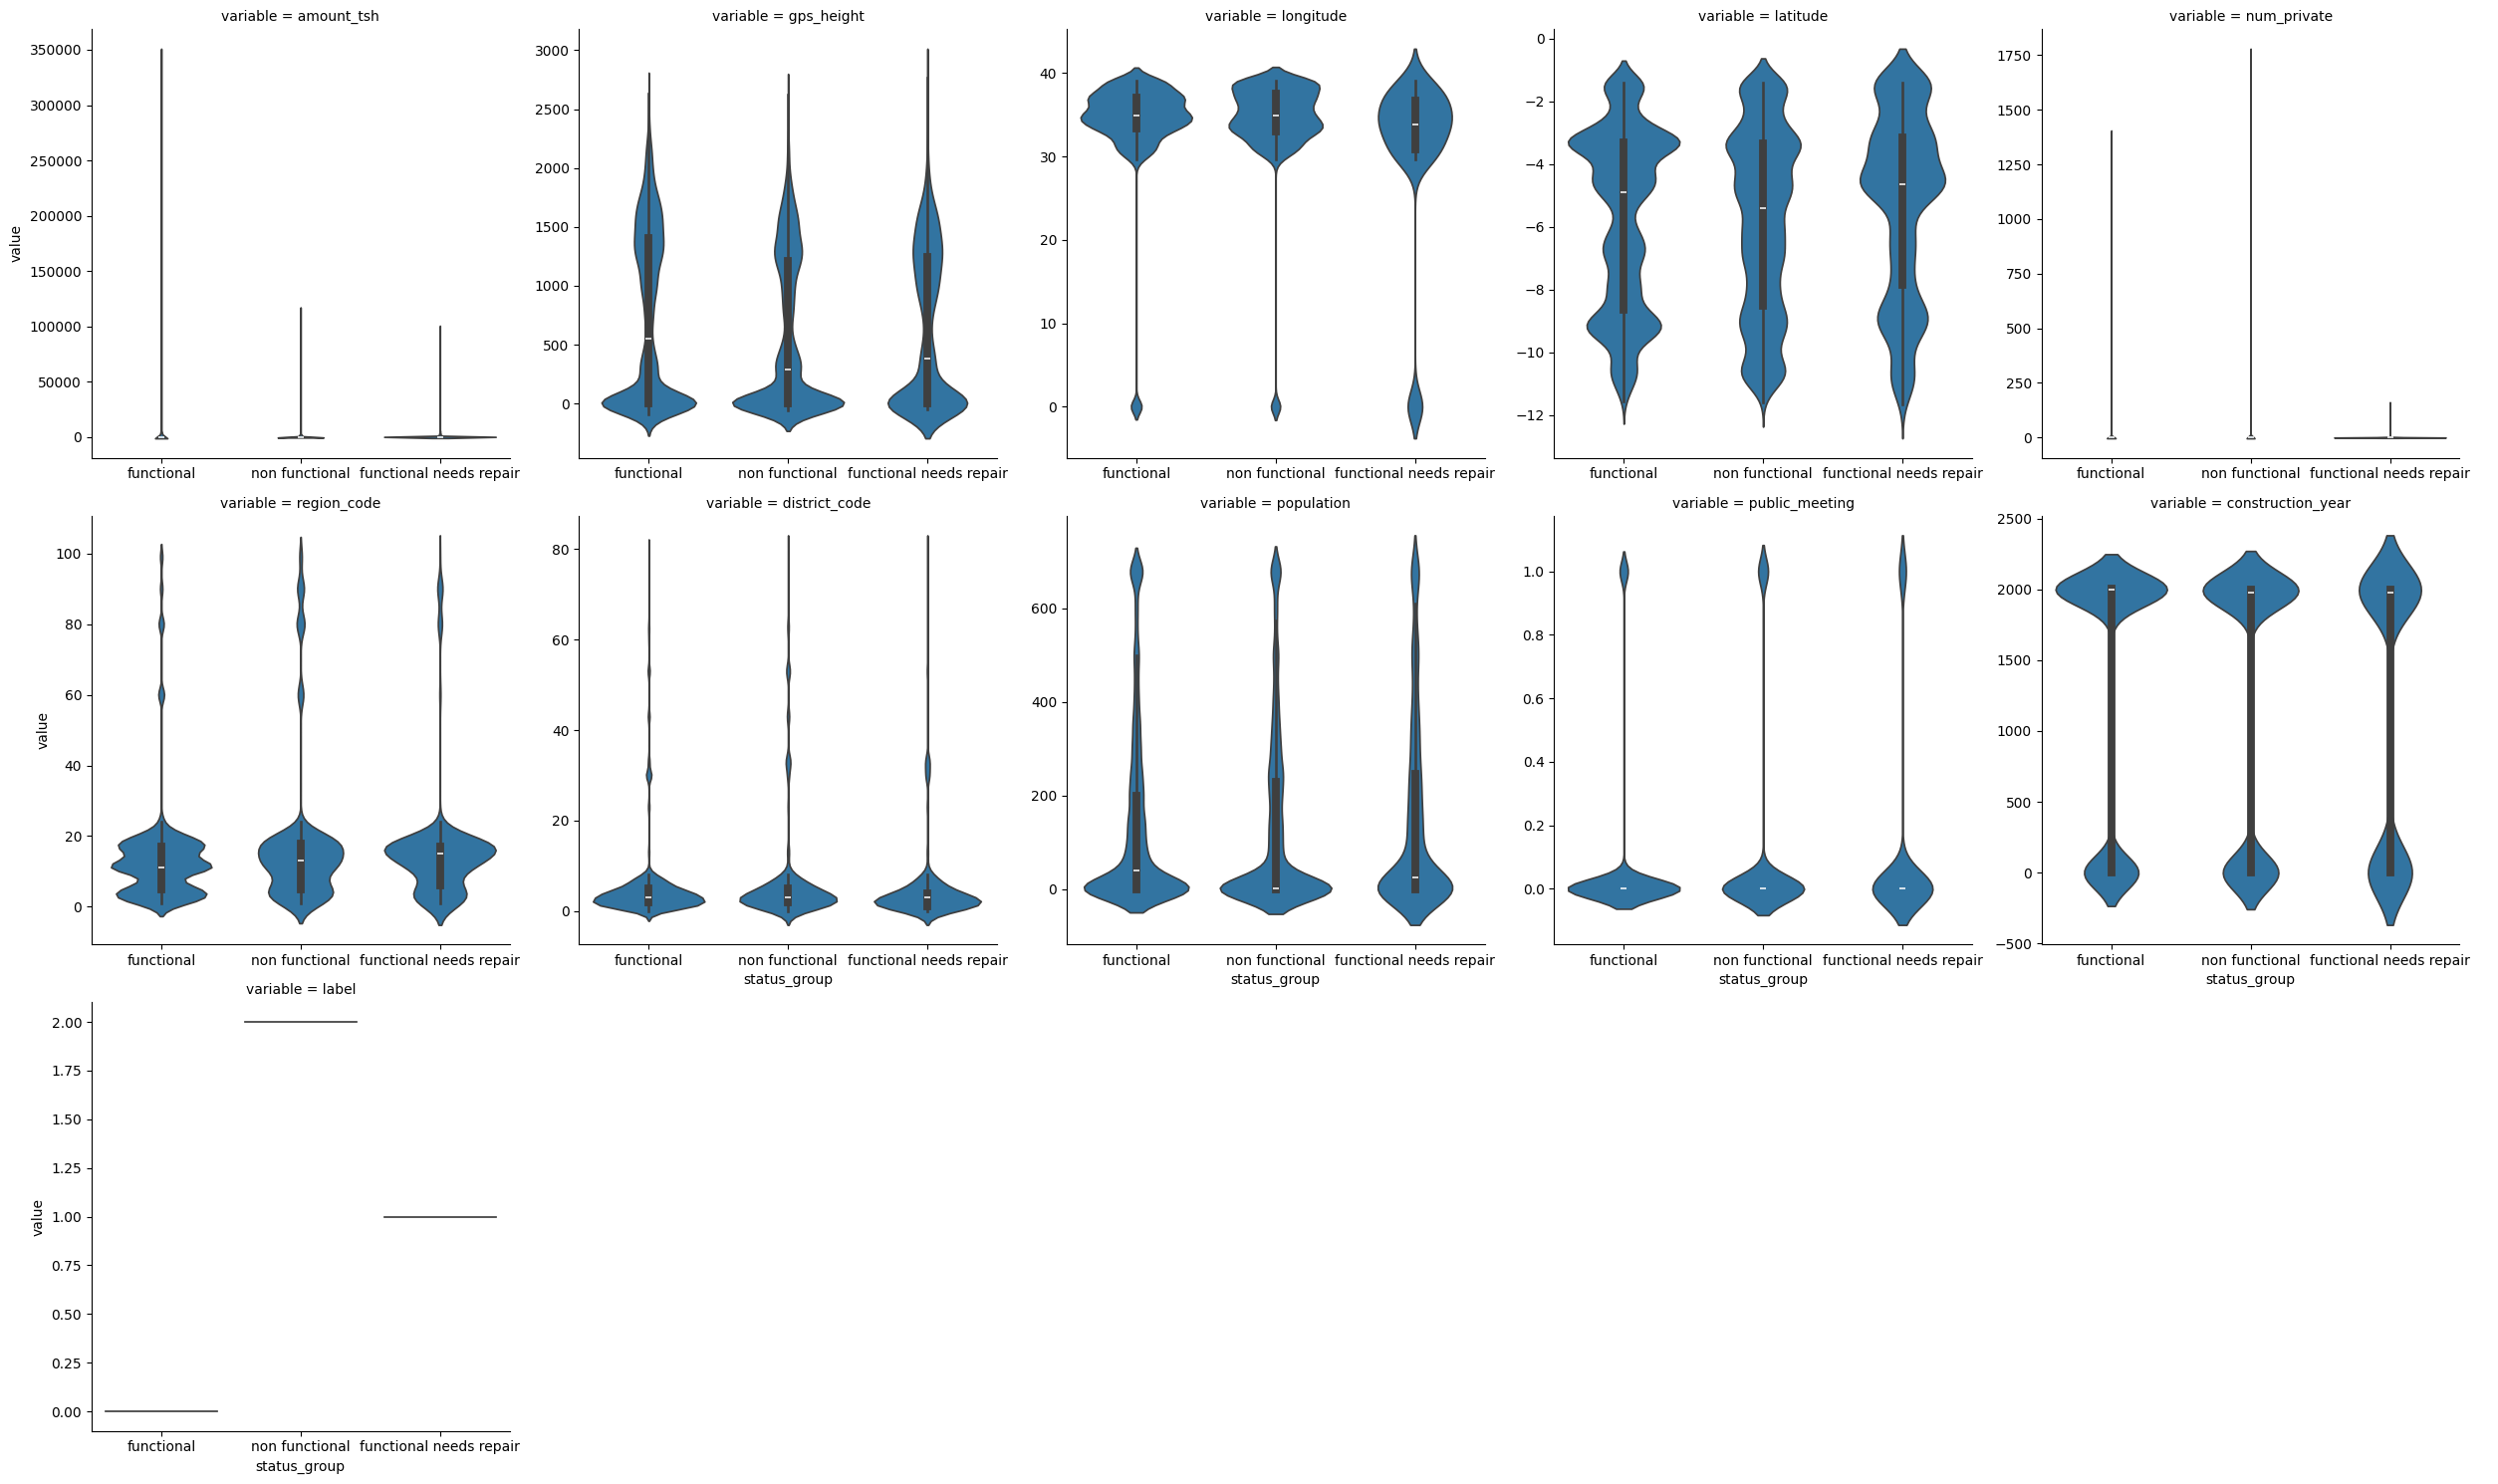

In [74]:
f = pd.melt( joined_df[numeric_cols+["status_group"]], id_vars='status_group', value_vars=numeric_cols)

g = sns.catplot(x="status_group" , y="value",
                col="variable",col_wrap=5,
                data=f, kind="violin",sharey=False,sharex=False);